## Step 0: Import Statements & Constants

In [1]:
import cv2
import numpy as np
import pdb
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

## Step 1: Derive Positions

#### Measure Position from Raw Footage

In [2]:
# V_CALIBRATION  = 0
# H_CALIBRATION  = 0

# # FLIR: workspace box bounded to real world coordinates of: upper left: (-0.3", 0.3") to bottom right: (4.4", 3.2")
# PIX_RANGE_X    = 1024
# PIX_RANGE_Y    = 1024
# MIN_X_PIX      = 0
# MAX_X_PIX      = MIN_X_PIX + PIX_RANGE_X
# MIN_Y_PIX      = 0
# MAX_Y_PIX      = MIN_Y_PIX + PIX_RANGE_Y
# WORLD_ORIGIN_TRANSLATION = 0
# WIDTH_IN_INCHES = 3.7
# PIX_TO_IN      = WIDTH_IN_INCHES / PIX_RANGE_X

# '''
# camera field of view offsets:
# 1024x1024, x-offset: 700, y-offset: 226
# '''

# # SIZE_IN_INCHES = 5.9
# # PIX_TO_IN      = SIZE_IN_INCHES / PIX_RANGE

# frame_count = 0
# background_frame = None
# # cap = cv2.VideoCapture(1)
# cap = cv2.VideoCapture('90fps-um.avi')

# # Open a CSV file for writing
# with open('um-positions.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(["h_pos", "v_pos"])  # Write header

#     start_time = time.time()
#     while True:
#         ret, frame = cap.read()
#         frame_count += 1
#         if not ret:
#             break
        
#         # Crop whole frame to target workspace area:
#         # [Y, X] components respectively, given the current orientation of the camera
#         workspace_frame = frame[MIN_Y_PIX : MAX_Y_PIX, MIN_X_PIX : MAX_X_PIX]

#         gray = cv2.cvtColor(workspace_frame, cv2.COLOR_BGR2GRAY)
#         gray = cv2.GaussianBlur(gray, (35, 35), 0)  # Filter for noise between frames

#         if background_frame is None:
#             background_frame = gray

#         frame_delta = cv2.absdiff(background_frame, gray)

#         # If any pixel intensity is < 25, set to 0. If > 25, set to 255
#         # Average over 6 iterations
#         _, thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)
#         thresh = cv2.dilate(thresh, None, iterations=6)

#         # Note contours x,y positions are defined based on the cropped frame!
#         contours, heirarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         for cnt in contours:
#             x, y, w, h = cv2.boundingRect(cnt)
#             h_pos = ((x + w/2) - WORLD_ORIGIN_TRANSLATION) * PIX_TO_IN
#             v_pos = (-1 * ((y + h/2) - WORLD_ORIGIN_TRANSLATION)) * PIX_TO_IN
#             print(round(h_pos, 2), round(v_pos, 2))
#             writer.writerow([round(h_pos, 2), round(v_pos, 2)])  # Write positions to CSV

#         # cv2.imshow('gray', gray)
#         cv2.imshow('color', workspace_frame)
#         cv2.imshow('threshold', thresh)
#         # print(frame.shape)  # 1080 * 1920 * 3 (rgb) -> (255, 255, 255)

#         cv2.imshow('frame', frame)
#         k = cv2.waitKey(5)
#         if k == 27:
#             break

# end_time = time.time()
# print(frame_count)
# print(end_time - start_time)
# cv2.destroyAllWindows()


#### Split Positions into Action Segments: A to B and B to A

In [96]:
# Load the data from the provided CSV file
data = pd.read_csv('ur-positions.csv')

# Define the positions A and B and the tolerance
position_A = np.array([2.31, -0.79])
position_B = np.array([1.52, -1.58])
tolerance = 0.2
repeating_threshold = 50

# Function to check if a position is within tolerance of a target position using Euclidean distance
def is_within_tolerance(pos, target, tol):
    return np.sqrt((pos[0] - target[0])**2 + (pos[1] - target[1])**2) <= tol

# Initialize variables
segments = []
current_segment = []
recording = False
repeating_count_A = 0
repeating_count_B = 0
last_pos_A = None
last_pos_B = None

for index, row in data.iterrows():
    pos = [row['h_pos'], row['v_pos']]
    
    if is_within_tolerance(pos, position_A, tolerance):
        if last_pos_A is not None and np.allclose(pos, last_pos_A, atol=tolerance):
            repeating_count_A += 1
        else:
            repeating_count_A = 1
        last_pos_A = pos
    else:
        repeating_count_A = 0
        last_pos_A = None

    if recording:
        current_segment.append(row)
        
        if is_within_tolerance(pos, position_B, tolerance):
            if last_pos_B is not None and np.allclose(pos, last_pos_B, atol=tolerance):
                repeating_count_B += 1
            else:
                repeating_count_B = 1
            last_pos_B = pos

            if repeating_count_B >= repeating_threshold:
                segments.append(pd.DataFrame(current_segment))
                current_segment = []
                recording = False
                repeating_count_B = 0
                last_pos_B = None
        else:
            repeating_count_B = 0
            last_pos_B = None

    if repeating_count_A >= repeating_threshold and not recording:
        recording = True
        current_segment = [row]

# Save each segment to a CSV file
for i, segment in enumerate(segments):
    segment.to_csv(f'segment_{i+1}.csv', index=False)

print(f'Total segments created: {len(segments)}')


Total segments created: 10


#### Plot Position of a Single Action

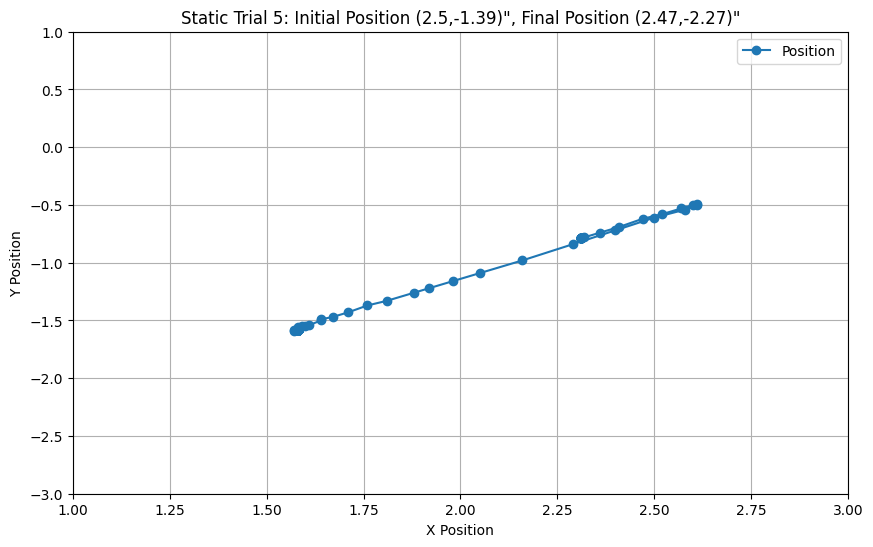

In [63]:
file_path = 'ur/center_to_ur/segment_1.csv'
df = pd.read_csv(file_path)

# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(df['h_pos'], df['v_pos'], 'o-', label='Position')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Static Trial 5: Initial Position (2.5,-1.39)", Final Position (2.47,-2.27)"')

# Set the x-axis range to show from 0 to 5
plt.xlim([1, 3])

# Set the y-axis range to show from -3.5 to -2
plt.ylim([-3, 1])

plt.legend()
plt.grid(True)
plt.show()

## Step 2: Derive Velocity & Acceleration for Each Segment

#### Organize Data: Load Trial CSVs Into Pandas DF

In [87]:
# import pandas as pd

# data_files = [
#     'um/um_to_center/segment_1.csv', 
#     'um/um_to_center/segment_2.csv', 
#     'um/center_to_um/segment_1.csv', 
#     'um/center_to_um/segment_2.csv', 
# ]

# all_data = []

# for file in data_files:
#     df = pd.read_csv(file)
#     new_column_names = ['x2', 'y2']
#     df.columns = new_column_names
#     all_data.append(df)

# combined_data = pd.concat(all_data, ignore_index=True)

# print(combined_data)

df = pd.read_csv('ur/ur_to_center/segment_1.csv')
x2, y2 = df.head(3)['h_pos'].mean(), df.head(3)['v_pos'].mean()
x1, y1 = df.tail(3)['h_pos'].mean(), df.tail(3)['v_pos'].mean()
positionA = [x2, y2]
positionB = [x1, y1]

new_column_names = ['x2', 'y2']
df.columns = new_column_names
df.ignore_index = True

print(positionA, positionB)
print(df)

[np.float64(2.46), np.float64(-0.68)] [np.float64(1.58), np.float64(-1.58)]
        x2    y2
0     2.46 -0.68
1     2.46 -0.68
2     2.46 -0.68
3     2.46 -0.68
4     2.46 -0.68
...    ...   ...
1542  1.58 -1.58
1543  1.58 -1.58
1544  1.58 -1.58
1545  1.58 -1.58
1546  1.58 -1.58

[1547 rows x 2 columns]


#### Compute Velocities and Accelerations

In [89]:
frame_rate = 83
time_step = 1 / frame_rate  # Replace with actual time steps if available

print(positionA)

vx = np.zeros(len(df))
vy = np.zeros(len(df))
ax = np.zeros(len(df))
ay = np.zeros(len(df))

threshold = 0.03 / (time_step)

for i in range(1, len(df) - 1):
    vx[i] = (df['x2'].iloc[i + 1] - df['x2'].iloc[i - 1]) / (2 * time_step)
    vy[i] = (df['y2'].iloc[i + 1] - df['y2'].iloc[i - 1]) / (2 * time_step)

# Use forward difference for the first point
vx[0] = (df['x2'].iloc[1] - df['x2'].iloc[0]) / time_step
vy[0] = (df['y2'].iloc[1] - df['y2'].iloc[0]) / time_step

# Use backward difference for the last point
vx[-1] = (df['x2'].iloc[-1] - df['x2'].iloc[-2]) / time_step
vy[-1] = (df['y2'].iloc[-1] - df['y2'].iloc[-2]) / time_step

vx[np.abs(vx) < threshold] = 0
vy[np.abs(vy) < threshold] = 0

# Calculate accelerations using central difference for interior points
for i in range(1, len(vx) - 1):
    ax[i] = (vx[i + 1] - vx[i - 1]) / (2 * time_step)
    ay[i] = (vy[i + 1] - vy[i - 1]) / (2 * time_step)

# Use forward difference for the first point
ax[0] = (vx[1] - vx[0]) / time_step
ay[0] = (vy[1] - vy[0]) / time_step

# Use backward difference for the last point
ax[-1] = (vx[-1] - vx[-2]) / time_step
ay[-1] = (vy[-1] - vy[-2]) / time_step

# Add velocities and accelerations to the dataframe
df['vx2'] = np.round(vx, 3)
df['vy2'] = np.round(vy, 3)
df['ax2'] = np.round(ax, 3)
df['ay2'] = np.round(ay, 3)


# Print initial and final values to check
print("Initial Values:")
print(df.head())

print("Final Values:")
print(df.tail())



[np.float64(2.46), np.float64(-0.68)]
Initial Values:
     x2    y2  vx2  vy2  ax2  ay2
0  2.46 -0.68  0.0  0.0  0.0  0.0
1  2.46 -0.68  0.0  0.0  0.0  0.0
2  2.46 -0.68  0.0  0.0  0.0  0.0
3  2.46 -0.68  0.0  0.0  0.0  0.0
4  2.46 -0.68  0.0  0.0  0.0  0.0
Final Values:
        x2    y2  vx2  vy2  ax2  ay2
1542  1.58 -1.58  0.0  0.0  0.0  0.0
1543  1.58 -1.58  0.0  0.0  0.0  0.0
1544  1.58 -1.58  0.0  0.0  0.0  0.0
1545  1.58 -1.58  0.0  0.0  0.0  0.0
1546  1.58 -1.58  0.0  0.0  0.0  0.0


#### Include Velocities and Accelerations Into DF and Persist

In [91]:
df['vx2'] = vx
df['vy2'] = vy
df['ax2'] = ax
df['ay2'] = ay

output_file_path = '/Users/akhilsankar/workspace/swarms/tracking/combined_static_trial_dfs/ur/segment_1.csv'
df.to_csv(output_file_path, index=False)

## Step 3: Regression

#### Define Physical Platform Dimensions

In [92]:
# raw measurements in mm
MM_TO_IN            = 0.0394
CASE_HEIGHT         = 12.50 * MM_TO_IN
COIL_HEIGHT         = 12.03 * MM_TO_IN
SHEET_THICKNESS     = 3.485 * MM_TO_IN
DISC_HEIGHT         = 1.75  * MM_TO_IN
R1                  = 9.455 * MM_TO_IN          # coil radius
R2                  = 2.965 * MM_TO_IN          # disc radius

# note: z2: position of disc along the z-axis wrt to the coil (by centroid)
z1 = 0
z2 = (COIL_HEIGHT / 2) + (CASE_HEIGHT - COIL_HEIGHT) + (2 * SHEET_THICKNESS) + (DISC_HEIGHT / 2)
h = z2 - z1


#### Define the State-Space Model

In [93]:
# def state_space_model(params, x2, y2, x1, y1, vx2, vy2):
#     '''
#     returns: predicted real-time acceleration in x and y directions

#     params: global variable representing target coefficients. these are constantly updated 
#     x1, y1: planar coordinates of the target destination (coil xy coordinates)
#         - this can be determined from the end position of each csv
#     x2, y2: real-time coordinates of the disc position
#     '''

#     alpha, beta1, beta2 = params
#     h = z2 - z1
#     r = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + h**2)
#     ax2_pred = -beta1 * vx2 + (alpha / r**5) * (1 - 5 * (h**2) / r**2) * (x2 - x1)
#     ay2_pred = -beta2 * vy2 + (alpha / r**5) * (1 - 5 * (h**2) / r**2) * (y2 - y1)
#     return np.concatenate([ax2_pred, ay2_pred])

def state_space_model(params, x2, y2, x1, y1, vx2, vy2):
    alpha, beta1, beta2 = params
    z2, z1 = 0.01, 0  # Assuming z2 and z1 are given and constant
    h = z2 - z1
    r = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + h**2)
    ax2_pred = -beta1 * vx2 + (alpha / r**5) * (1 - 5 * (h**2) / r**2) * (x2 - x1)
    ay2_pred = -beta2 * vy2 + (alpha / r**5) * (1 - 5 * (h**2) / r**2) * (y2 - y1)
    return np.concatenate([ax2_pred, ay2_pred])

#### Define the Objective Function (SSD)

#### Optimize Parameters Using Curve Fit (Levenberg-Marquardt) 

In [94]:
# # Initial parameter guesses
# initial_guesses = [0.1, 0.1, 0.1]

# 0.1 0.1 0.1
#  [ 3.99165386e-06, -9.11637689e-02,  3.37911556e-04]
#  2.36227858e-04  2.57866196e-02 -5.71059168e-01]

initial_guesses = [ 3.99165386e-06, -9.11637689e-02,  3.37911556e-04]
x1, y1 = position_B[0], position_B[1]


def model_func_lambda(inputs, alpha, beta1, beta2):
    x2, y2, vx2, vy2 = inputs

    return state_space_model([alpha, beta1, beta2], x2, y2, x1, y1, vx2, vy2)

try:
    optimized_params, covariance = curve_fit(
        model_func_lambda, (df['x2'], df['y2'], df['vx2'], df['vy2']),
        np.concatenate([df['ax2'], df['ay2']]),
        p0=initial_guesses
    )
    print("Optimized parameters:", optimized_params)
except Exception as e:
    print("Error during curve fitting:", e)

Optimized parameters: [ 3.99166746e-06 -9.12801496e-02  8.93935507e-04]


## Performance: Simulation vs Experiments

#### Calculate Acceleration -> Velocity -> Displacement -> Final Position

In [95]:
def sim_state_space_model(params, x2, y2, x1, y1, vx2, vy2):
    alpha, beta1, beta2 = params
    h = 0.01  # Replace with actual height difference
    r = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + h**2)
    ax2_pred = -beta1 * vx2 + (alpha / r**5) * (1 - 5 * (h**2) / r**2) * (x2 - x1)
    ay2_pred = -beta2 * vy2 + (alpha / r**5) * (1 - 5 * (h**2) / r**2) * (y2 - y1)
    return ax2_pred, ay2_pred  # Return as scalars, not as concatenated array



# Given parameters
alpha_opt, beta1_opt, beta2_opt = optimized_params # Replace with optimized parameters

# Initial conditions
print('target position: ', position_B[0], position_B[1])
x2_pred, y2_pred = position_A[0], position_A[1]  # Initial positions
vx2_pred, vy2_pred = 0.0, 0.0  # Initial velocities

# Simulation parameters
dt = 1 / frame_rate # Time step
num_steps = 2000  # Number of steps in the simulation

# Arrays to store the results
x2_pred_array = np.zeros(num_steps)
y2_pred_array = np.zeros(num_steps)
vx2_pred_array = np.zeros(num_steps)
vy2_pred_array = np.zeros(num_steps)
ax2_pred_array = np.zeros(num_steps)
ay2_pred_array = np.zeros(num_steps)

# Simulation loop using Euler method
for i in range(num_steps):
    ax2_pred, ay2_pred = sim_state_space_model(
        [alpha_opt, beta1_opt, beta2_opt], 
        x2_pred, y2_pred, x1, y1, vx2_pred, vy2_pred
    )
    
    # Store the results
    x2_pred_array[i] = x2_pred
    y2_pred_array[i] = y2_pred
    vx2_pred_array[i] = vx2_pred
    vy2_pred_array[i] = vy2_pred
    ax2_pred_array[i] = ax2_pred
    ay2_pred_array[i] = ay2_pred
    
    # Update velocities using Euler method
    vx2_pred += ax2_pred * dt
    vy2_pred += ay2_pred * dt
    
    # Update positions using Euler method
    x2_pred += vx2_pred * dt
    y2_pred += vy2_pred * dt

# Combine results into a DataFrame for analysis

results_df = pd.DataFrame({
    'time': np.arange(num_steps) * dt,
    'x2': x2_pred_array,
    'y2': y2_pred_array,
    'vx2': vx2_pred_array,
    'vy2': vy2_pred_array,
    'ax2': ax2_pred_array,
    'ay2': ay2_pred_array
})

print(results_df[['ax2', 'ay2']])
final_sim_position = ['x2', 'y2']
print(results_df[final_sim_position].tail(10))


target position:  1.52 -1.58
           ax2       ay2
0     0.000002  0.000002
1     0.000002  0.000002
2     0.000002  0.000002
3     0.000002  0.000002
4     0.000002  0.000002
...        ...       ...
1995  0.000016  0.000002
1996  0.000016  0.000002
1997  0.000016  0.000002
1998  0.000016  0.000002
1999  0.000016  0.000002

[2000 rows x 2 columns]
            x2        y2
1990  2.311245 -0.789483
1991  2.311247 -0.789483
1992  2.311249 -0.789482
1993  2.311251 -0.789482
1994  2.311253 -0.789481
1995  2.311254 -0.789481
1996  2.311256 -0.789480
1997  2.311258 -0.789480
1998  2.311260 -0.789479
1999  2.311262 -0.789479
